[158526219]
[158526219, 158526219]
[158526219, 158526219, 158526219]
size of folder doesn't change
29616_SC_MA_GCMS_H-1-845-29010_Bio21-LC-QTOF-6545.mzml
Chromatogram has no property mz.
Return retention time instead


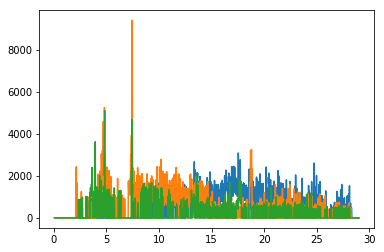

{"file name": "29616_SC_MA_GCMS_H-1-845-29010_Bio21-LC-QTOF-6545.mzml", "start time": 0.06516666666666666, "end time": 28.994583333333335, "length": 28.92941666666667, "instrument": " ", "EIC": [{"target": 100, "RTs": [0.065166666667, 0.08605, 0.10695, 0.127833333333, 0.148716666667, 0.1696, 0.1905, 0.211383333333, 0.232266666667, 0.25315, 0.27405, 0.294933333333, 0.315816666667, 0.3367, 0.3576, 0.378483333333, 0.399366666667, 0.42025, 0.44115, 0.462033333333, 0.482916666667, 0.5038, 0.5247, 0.545583333333, 0.566466666667, 0.58735, 0.60825, 0.629133333333, 0.650016666667, 0.6709, 0.6918, 0.712683333333, 0.733566666667, 0.75445, 0.77535, 0.796233333333, 0.817116666667, 0.838, 0.8589, 0.879783333333, 0.900666666667, 0.92155, 0.94245, 0.963333333333, 0.984216666667, 1.0051, 1.026, 1.046883333333, 1.067766666667, 1.08865, 1.10955, 1.130433333333, 1.151316666667, 1.1722, 1.1931, 1.213983333333, 1.234866666667, 1.25575, 1.27665, 1.297533333333, 1.318416666667, 1.3393, 1.3602, 1.381083333333,

In [ ]:
#use watchdog to monitor folder
from watchdog.observers import Observer
from watchdog.events import *
import time
import re
import os
from os.path import join, getsize
import sys
import numpy as np
import pymzml
import matplotlib.pyplot as plt
import json

class FileEventHandler(FileSystemEventHandler):
    def __init__(self):
        FileSystemEventHandler.__init__(self)
     
     #get the size of a folder   
    def getdirsize(self,dir):
        size=0
        for root, dirs, files in os.walk(dir):
            size+= sum([getsize(join(root, name)) for name in files])
        return size
    
    def produceJson(self,mzmlName):
        jfile_path=r"C:\Users\shary\Desktop\computingProject"        
        jfile_pathname=jfile_path+"\\"+mzmlName.split('.')[0]+".json"
        f=open(jfile_pathname,'a')
        f.close
        
        js={}#create a empty dict for json data
        js['file name']=mzmlName
        
        msrun = pymzml.run.Reader(mzmlName, obo_version = '3.71.0') 
        times = msrun['TIC'].mz
        intensities = msrun['TIC'].i
        length =  max(times) - min(times)
        js['start time']=min(times)
        js['end time']=max(times)
        js['length']=length
        js['instrument']=' '#how to get instrument???
        
        msrun = pymzml.run.Reader(mzmlName, obo_version = '3.71.0')
        eicTargets = [100, 200, 300] # user defined
        eicTol = 0.03 # user defined
        results = []
        for eicTarget in eicTargets:
            results.append( {
                'target': eicTarget,
                'RTs' : [], # list to hold retention times
                'ints' :  [], # list to hold intensities
                'lowerLimit' : eicTarget - eicTol,
                'upperLimit' : eicTarget + eicTol
                }
            )
        
        for spectrum in msrun:
            try:
                time = spectrum['scan start time']
            except:
                break 
            mzs = np.asarray(spectrum.mz,dtype=np.float64)
            ints = np.asarray(spectrum.i,dtype=np.float64) 
            for target in results:
                lowerLimit = target['lowerLimit']
                upperLimit = target['upperLimit']
                mask = np.where( (mzs > lowerLimit) & (mzs < upperLimit) ) 
                eicInts = ints[mask]
                target['RTs'].append(time)
                target['ints'].append(np.sum(eicInts))
        for target in results:
            plt.plot(target['RTs'], target['ints'])
        plt.show()
        js['EIC']=results
        #print(js)
        js_final=json.dumps(js)
        print(js_final)
        file=open(jfile_pathname,'w')
        file.write(js_final)
        file.close()
        
            

#when new files/folders come in        
    def on_created(self, event):
       # print "log file %s changed!" % event.src_path
        s=event.src_path
        if s.endswith('.d'):
            convertname=s.replace("\\","\\\\")
            size_list=[]
            while True:
                foldersize=self.getdirsize(s)
                size_list.append(foldersize)
                print (size_list)
                
                if len(size_list)>2:
                    #print size_list[len(size_list)-1]
                    #print size_list[len(size_list)-3]
                    if size_list[len(size_list)-1]==size_list[len(size_list)-3]:                   
                        print ("size of folder doesn't change")
                        break
                #every 5 minutes    
                time.sleep(1)    
                
            #put mzml file in the file that contain this code file        
            cmd="msconvert " +convertname+ r" -o C:\Users\shary\Desktop\computingProject"
            os.system(cmd)
            dName=convertname.split("\\")[len(convertname.split("\\"))-1]
            mzmlName=dName.replace(".d",".mzml")
            print(mzmlName)
                        
            #when convert to mzml, produce json file
            #self.produceJson("pbQC009.mzML")#change it to mzmlName
            self.produceJson(mzmlName)


"""
        if event.is_directory:
            print("directory created:{0}".format(event.src_path))
        else:
            print("file created:{0}".format(event.src_path))
"""        
"""
#when remove files/folers
    def on_moved(self, event):
       if event.is_directory:
            print("directory moved from {0} to {1}".format(event.src_path,event.dest_path))
        else:
            print("file moved from {0} to {1}".format(event.src_path,event.dest_path))

    def on_deleted(self, event):
        if event.is_directory:
            print("directory deleted:{0}".format(event.src_path))
        else:
            print("file deleted:{0}".format(event.src_path))

    def on_modified(self, event):
        if event.is_directory:
            print("directory modified:{0}".format(event.src_path))
        else:
            print("file modified:{0}".format(event.src_path))
"""    
    

if __name__ == "__main__":
    observer = Observer()
    event_handler = FileEventHandler()
    observer.schedule(event_handler,r"C:\Users\shary\Desktop\computingProject\input",True)
    observer.start()
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        observer.stop()
    observer.join()

In [42]:
#create a new file
import os
f=open(r"C:\Users\shary\Desktop\computingProject\test.json")
f.close

<function TextIOWrapper.close>

In [37]:
#write in a file
file=open(r"C:\Users\shary\Desktop\computingProject\test.json",'w')
file.write("abcdefg")
file.close()

In [38]:
import json
test_json={}
test_filename={'filename': 'x.mzml'}
test_json['filename']='x.mzml'
test_starttime={'start time':'5'}
test_json['start time']='5'
print(test_json)
test_js=json.dumps(test_json)
print(test_js)
file=open(r"C:\Users\shary\Desktop\computingProject\test.json",'w')
file.write(test_js)
file.close()

{'filename': 'x.mzml', 'start time': '5'}
{"filename": "x.mzml", "start time": "5"}


In [43]:
test_mzml='abcde.mzml'
test_pathname=r"C:\Users\shary\Desktop\computingProject"+test_mzml.split('.')[0]+".json"
print(test_pathname)

C:\Users\shary\Desktop\computingProjectabcde.json


In [56]:
import os
f=open(r"C:\Users\shary\Desktop\computingProject\test1.json",'a')
f.close

<function TextIOWrapper.close>